In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import run

In [45]:
file = "../../data/0.365-0.656.pkl"

with open(file, "rb") as f:
    [(b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2), sol, phase, χ, m] = pickle.load(f)

metadata = pd.read_excel("../connectomes/mouse_meta.xlsx", sheet_name=None)

m = metadata["Voxel Count_295 Structures"]
del(metadata)
m = m.loc[m["Represented in Linear Model Matrix"] == "Yes"]

columns = []
cortices = [[0, 0]]
for region in m["Major Region"].unique():
    i = [columns.append(acronym.replace(" ", "")) for acronym in
         m.loc[m["Major Region"] == region, "Acronym"].values]
    cortices.append([cortices[-1][-1], cortices[-1][-1] + len(i)])
cortices.remove([0, 0])

In [46]:
χ = run.chimera(phase, cortices)

ρ_bar = np.mean(np.array([run.order(phase[:, low:high])
                       for [low, high] in cortices]),
             axis=0)

chi = np.sum(np.array([(run.order(phase[:, low:high]) - ρ_bar)**2
                       for [low, high] in cortices]), axis=0)/len(cortices)

title = f"alpha: {α:.03f}, beta: {β:.03f}, chi: {χ:.04f}"

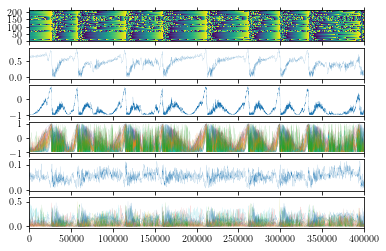

In [61]:
fig, [overhead,
      order,
      cos_mean,
      by_cortex_cos_mean,
      variance,
      by_cortex_variance] = plt.subplots(6, 1, sharex=True, squeeze=True)
overhead.set_xlim([0, phase.shape[0]])

overhead.matshow(phase.T, aspect="auto", origin="lower")

cos_mean.plot(np.cos(np.mean(phase, axis=1)), lw=0.1)

for cortex in cortices:
    [low, high] = cortex
    by_cortex_cos_mean.plot(np.cos(np.mean(phase[:, low:high], axis=1)),
                            label=f"{low + 1}-{high}", lw=0.07)

order.plot(run.order(phase), lw=0.1)

variance.plot(chi, lw=0.1)

for cortex in cortices:
    [low, high] = cortex
    by_cortex_variance.plot(((run.order(phase[:, low:high]) - ρ_bar)**2),
                            label=f"{low + 1}-{high}", lw=0.07)

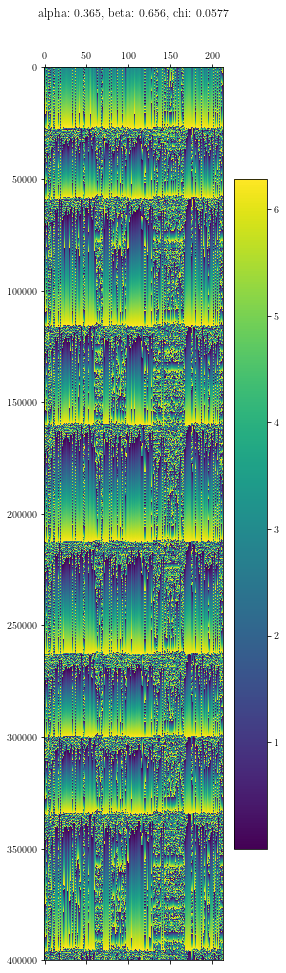

In [62]:
plt.matshow(phase, aspect="auto")
plt.title(title)
plt.colorbar()
plt.savefig(f"{α:.03f}-{β:.03f}-overhead.png", dpi=500, bbox_inches="tight", format="png")

In [ ]:
plt.plot(np.cos(np.mean(phase, axis=1)))
plt.title(title)
plt.xlabel("time")
plt.ylabel("cos(mean(phase))")
plt.savefig(f"{α:.03f}-{β:.03f}-cos_mean.png", dpi=500, bbox_inches="tight", format="png")

for cortex in cortices:
    [low, high] = cortex
    plt.plot(np.cos(np.mean(phase[:, low:high], axis=1)),
             label=f"{low + 1}-{high}", lw=0.05)

plt.xlabel("time")
plt.ylabel("cos(mean(phi))")
    
plt.legend(bbox_to_anchor=(1, 1))
plt.title(title)
plt.savefig(f"{α:.03f}-{β:.03f}-by_cortex_cos_mean.png", dpi=500, bbox_inches="tight", format="png")

plt.plot(run.order(phase))
plt.xlabel("time")
plt.ylabel("rho")
plt.title(title)
plt.savefig(f"{α:.03f}-{β:.03f}-order.png", dpi=500, bbox_inches="tight", format="png")

plt.plot(chi)
plt.xlabel("time")
plt.ylabel("sigma(chi(t))")
plt.title(title)
plt.savefig(f"{α:.03f}-{β:.03f}-chi.png", dpi=500, bbox_inches="tight", format="png")
plt.cla()
plt.clf()

for cortex in cortices:
    [low, high] = cortex
    plt.plot(((run.order(phase[:, low:high]) - ρ_bar)**2),
             label=f"{low + 1}-{high}", lw=0.05)

plt.xlabel("time")
plt.ylabel("(rho - rho bar)**2")
plt.legend(bbox_to_anchor=(1, 1))
plt.title(title)
plt.savefig(f"{α:.03f}-{β:.03f}-by_cortex_variance.png", bbox_inches="tight", format="png")